# Gaussian Mixture Model

The main aims of this tutorial are (i) to get experience in fitting Gaussian mixture models using *sklearn* module, and to (ii) assess several methods for choosing the number of clusters. Furthermore, we'll see how a fitted model allows us to make predictions.

We start with same old initialisation line.

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


## Sampling from a Gaussian mixture

Now let's generate data originated from several Gaussians. We will need quite a few parameters to generate such a dataset. To begin with we need to decide how many components (clusters) to generate, for example we can start with $3$ clusters. For each cluster, we need to decide how many points to sample. We can keep these numbers in an array.

In [2]:
n = np.array([30, 20, 10])

In this tutorial, we are going to use 2D data for visualisation purposes. Thus each Gaussian is defined by a 2D mean vector and a $2\times2$ covariance matrix. Let's collate all mean information into one array.

In [3]:
u1 = np.array([0, 0]) # mean of the 1st component
u2 = np.array([50, 60]) # mean of the 2nd component
u3 = np.array([0, 100]) # mean of the 3rd component
u = np.vstack((u1, u2, u3))

Covariance matrices have to by symmetric. Hence there are only $3$ parameters incurred by each matrix. For each Gaussian, suppose we keep covariance matrix values in an array, such that the first element is the variance along the x-axis, the second element is the variance along the y-axis, and the last element is covariance. Again, let's collate all variance/covariance information into a single array.

In [4]:
v1 = np.array([160, 180, 20])
v2 = np.array([170, 120, 30])
v3 = np.array([130, 130, 40])
v = np.vstack((v1, v2, v3))

Now implement a function that will generate us a random sample from a Gaussian mixture defined by parameters $n$, $u$, and $v$.

In [5]:
def generate_data(n, u, v):
    data = np.empty((0, 2), double)
    k = n.shape[0]
    for c in range(0, k):
        print("=== cluster #" + str(c+1) + " (" + str(n[c]) + " points) ===")
        print("mean")
        print(u[c,:])
        print("covariance matrix")
        s = np.array([[v[c,0], v[c,2]],[v[c,2], v[c,1]]])
        print(s)
        cData = np.random.multivariate_normal(u[c,:], s, n[c])
        print('Data generated for components # : ', c+1 , 'with Dimension : ', cData.shape)
        data = np.vstack((data, cData))
        print("")
    return data

Let's try this out.

=== cluster #1 (30 points) ===
mean
[0 0]
covariance matrix
[[160  20]
 [ 20 180]]
Data generated for components # :  1 with Dimension :  (30, 2)

=== cluster #2 (20 points) ===
mean
[50 60]
covariance matrix
[[170  30]
 [ 30 120]]
Data generated for components # :  2 with Dimension :  (20, 2)

=== cluster #3 (10 points) ===
mean
[  0 100]
covariance matrix
[[130  40]
 [ 40 130]]
Data generated for components # :  3 with Dimension :  (10, 2)



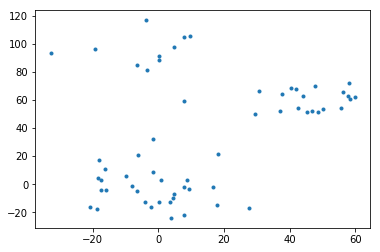

In [ ]:
data = generate_data(n, u, v)
plt.plot(data[:,0], data[:,1], '.')

## Fitting a Gaussian mixture model

Now that we have data, let's fit a Gaussian mixture model (GMM). This can be done just in a couple of lines of code using *sklearn*. Note that the fitting procedure implements expectation maximisation algorithm. We have to specify the number of clusters, and at first let's specify the true number. The *covariance_type* parameter allows one to make fitting more efficient by, e.g., restricting Gaussians to spherical shapes. In our case, we do not impose any additional restrictions on the covariance matrices, and hence use the *full* option.

In [ ]:
import warnings
warnings.filterwarnings('ignore') 
from sklearn import mixture
gmix = mixture.GMM(n_components=3, covariance_type='full')
gmix.fit(data)

We can explore the estimated parameters of the fitted model. Parameters include weights, means and covariance matrices for each Gaussian component.

In [ ]:
print(gmix.weights_)

In [ ]:
print(gmix.means_)

In [ ]:
print(gmix.covars_)

For a 2D data, we can also visualise the fitted model. The 2D Gaussians can be represented with isoline ellipsoids. For each Gaussian component, the ellipsoid is a location of points that have the same probability. Plotting an ellipsoid for a given 2D Gaussian, is somewhat non-trivial, and we are going to use a function developed for this purpose. Understanding the code and theory of function *plot_cov_ellipse* is not necessary for this tutorial. 

In [ ]:
# adapted from http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/
# and https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, fc='none', ec=[0,0,0], a=1, lw=2):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    from scipy.stats import chi2
    from matplotlib.patches import Ellipse
    
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':a, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)

    ax.add_artist(ellip)
    return ellip

Using the above function, implement visualisation that plots data overlaid with fitted Gaussian ellipsoids.

In [ ]:
import warnings
warnings.filterwarnings('ignore') 
def plot_gmm(data, gmm):
    plt.scatter(data[:,0], data[:,1],c=gmm.predict(data), lw=0)
    k = gmm.weights_.shape[0]    
    for c in range(0, k):
        plot_cov_ellipse(gmm.covars_[c], gmm.means_[c])

In [ ]:
plot_gmm(data, gmix)

*Experiment with fitting to different datasets, including samples with overlapping clusters*

## Making predictions using the model

The power of a probabilistic model is in the ability to make predictions. That is, for each point, either from the dataset or a new point, we can now assess the probabilities that the point originated from each of the components. We can then assign the point to the most probable component (cluster). In other words, we can predict the cluster for the point, and this can be done using a standard function provided within the *mixture* module.

First, let's cluster each point from the original dataset.

In [ ]:
plt.scatter(data[:,0], data[:,1], c=gmix.predict(data), lw=0)

Next, generate a gird of regularly spaced points and see how the entire space is divided into clusters.

In [ ]:
delta = 1

xMin = np.round(np.min(data[:,0])) - 5
xMax = np.round(np.max(data[:,0])) + 5
yMin = np.round(np.min(data[:,1])) - 5
yMax = np.round(np.max(data[:,1])) + 5

xSpace = np.arange(xMin, xMax, delta)
ySpace = np.arange(yMin, yMax, delta)
xGrid, yGrid = np.meshgrid(xSpace, ySpace)

newData = transpose(np.stack((np.ravel(xGrid), np.ravel(yGrid))))
print(newData.shape)

plt.scatter(newData[:,0], newData[:,1], c=gmix.predict(newData), lw=0)

## Fitting the wrong number of clusters

What would happen if we specify a wrong number of clusters?

In [ ]:
gmix2 = mixture.GMM(n_components=2, covariance_type='full')
gmix2.fit(data)
plot_gmm(data, gmix2)

In [ ]:
gmix4 = mixture.GMM(n_components=5, covariance_type='full')
gmix4.fit(data)
plot_gmm(data, gmix4)

*What can you conclude from this exercise?*

## Estimating the number of clusters

For this part of the tutorial, let's generate a more complicated dataset with a larger number of clusters.

In [ ]:
u1 = np.array([0, 0])
u2 = np.array([50, 60])
u3 = np.array([0, 100])
u4 = np.array([100, -20])
u5 = np.array([-20, 40])
u = np.vstack((u1, u2, u3, u4, u5))

v1 = np.array([160, 180, 20])
v2 = np.array([170, 120, 30])
v3 = np.array([130, 130, 40])
v4 = np.array([130, 130, 40])
v5 = np.array([130, 130, 40])
v = np.vstack((v1, v2, v3, v4, v5))

n = np.array([30, 20, 10, 25, 25])
data = generate_data(n, u, v)
plt.plot(data[:,0], data[:,1], '.')

In reality, we usually do not know the true number of clusters, so let's try to estimate it solely from the data. We are going to try a few different approaches, including heldout cross validation log-likelihood , AIC and BIC. Before we begin, generate heldout data from the same distribution as original data.

In [ ]:
n = np.array([30, 20, 10, 25, 25])
heldOutData = generate_data(n, u, v)
plt.plot(data[:,0], data[:,1],'.', label= 'train-data')
plt.plot(heldOutData[:,0], heldOutData[:,1],'*',label='holdout-data')
plt.legend()

Now fit Gaussian mixture models to the data using various cluster numbers. After each fit, you will be able to access a few quantities that we are going to use. If *gmix* is a fitted model, then *gmix.score(X)* returns log-likelihood for each point in *X*, *gmix.aic* returns the AIC, and *gmix.bic* returns the BIC for the fitted model. Note that in practice it is recommended to use AIC corrected for small sample sizes. The corrected version is defined as $AICc=AIC+2n_{par}(n_{par}+1)/(n-n_{par}-1)$, where $n_{par}$ is the number of free parameters, and $n$ is the number of data points.

Now fit Gaussian mixture models to the data using various cluster numbers, and for each number, record log-likelihood, cross validated log-likelihood, AIC, AICc, BIC and number of free parameters.

In [ ]:
kRange = range(1,10)
nk = len(kRange)
ll = np.zeros(nk)
ll2 = np.zeros(nk)
aic = np.zeros(nk)
aicc = np.zeros(nk)
bic = np.zeros(nk)
nParams = np.zeros(nk) # number of free parameters
nSamples = data.shape[0] # sample size

for i in range(0, nk):
    gmix = mixture.GMM(n_components=kRange[i], covariance_type='full')
    gmix.fit(data)
    ll[i] = np.sum(gmix.score(data))
    ll2[i] = np.sum(gmix.score(heldOutData))
    aic[i] = gmix.aic(data)
    bic[i] = gmix.bic(data)    
    nParams[i] = kRange[i]*(1 + 2 + 3) - 1 # number of free parameters
    aicc[i] = aic[i] + 2*nParams[i]*(nParams[i] + 1) / (nSamples - nParams[i] - 1)

Now plot all these quantities as a function of hypothesised number of clusters. *Analyse the resulting plots. What can you tell about the number of parameters? Can all of these quantities be used to estimate the number of clusters?*

In [ ]:
logl_data = plt.plot(kRange, ll, 'b.-',label = 'Data log-likelihood')
logl_dataholdout = plt.plot(kRange, ll2, 'k.-', label = 'HoldOut log-likelihood')
#plt.legend()
plt.xlabel('k - # of components')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

In [ ]:
plt.plot(kRange, nParams, 'c.-', label = '# of Parameters')
plt.plot(kRange, np.repeat(nSamples, len(kRange)), 'y.-', label = '# of Samples')
plt.xlabel('k - # of components')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

In [ ]:
plt.plot(kRange, aic, 'r.-', label = 'AIC')
plt.plot(kRange, aicc, 'm.-',label = 'AICc')
plt.plot(kRange, bic, 'g.-', label = 'BIC')
plt.xlabel('k - # of components')
plt.legend()
#plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)